In [1]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import random 

/data/home/qian_hong/anaconda3/envs/bcg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(42)  # 设置固定的随机种子
random.seed(42)     # 同时设置Python的random种子

In [3]:
data = np.load('/data/home/qian_hong/signal/vitaldb/0/train/signals.npz',allow_pickle=True)
len_train = data['Subject'].shape[0]
data = np.load('/data/home/qian_hong/signal/vitaldb/0/val/signals.npz',allow_pickle=True)
len_val = data['Subject'].shape[0]
data = np.load('/data/home/qian_hong/signal/vitaldb/0/test/signals.npz',allow_pickle=True)
len_test = data['Subject'].shape[0]


In [4]:
import torch

# 模拟输入张量
y_out = torch.rand(100)  # Shape: (100,)
y_label = torch.rand(100)  # Shape: (100,)

# 计算点积
point_similarity = torch.dot(y_out, y_label)  # 点积结果是一个标量

print("y_out shape:", y_out.shape)
print("y_label shape:", y_label.shape)
print("Point similarity:", point_similarity.item())  # 转换为 Python 浮点数

y_out shape: torch.Size([100])
y_label shape: torch.Size([100])
Point similarity: 24.60358238220215


In [8]:
import numpy as np

def compute_similarity(y_out, y_label):
    """
    Compute point similarity, MSE, and cosine similarity between two signals.
    
    Args:
        y_out (np.ndarray): Predicted signal, shape (seq_length,).
        y_label (np.ndarray): Ground truth signal, shape (seq_length,).

    Returns:
        dict: Dictionary containing point similarity, MSE, and cosine similarity.
    """
    # Ensure the inputs are numpy arrays
    y_out = np.asarray(y_out)
    y_label = np.asarray(y_label)

    # Point similarity (Dot product)
    point_similarity = np.dot(y_out, y_label)

    # Mean Squared Error (MSE)
    mse = np.mean((y_out - y_label) ** 2)

    # Cosine similarity
    norm_out = np.linalg.norm(y_out)
    norm_label = np.linalg.norm(y_label)
    cosine_similarity = np.dot(y_out, y_label) / (norm_out * norm_label)


    return point_similarity,mse,cosine_similarity



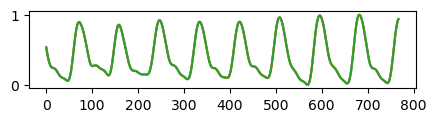

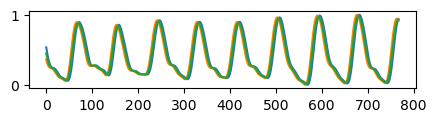

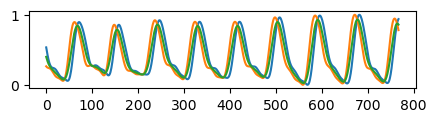

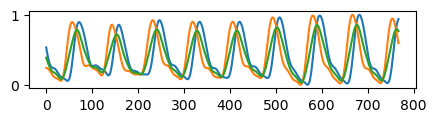

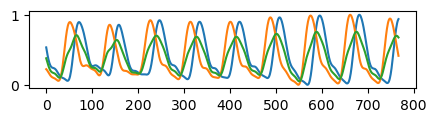

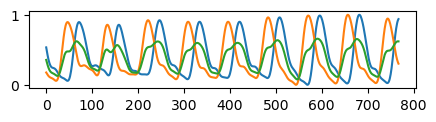

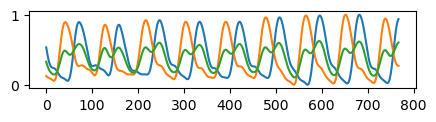

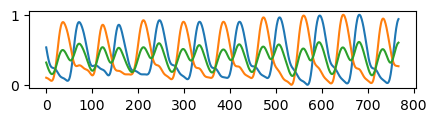

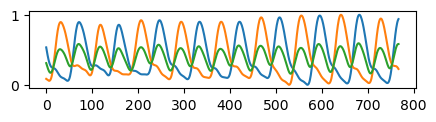

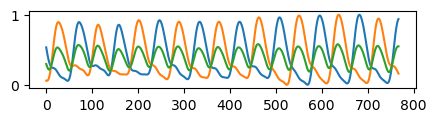

In [20]:
idx=2
signal = data['ppg'][0]
start =100

for shift in range(0,50,5):

    (start_B, end_B) = start+shift,start+len+shift
    (start_A, end_A) = start+0,start+0+len
    # print(start_A, end_A,start_B, end_B)

    sigA = signal[start_A:end_A]
    sigB = signal[start_B:end_B]
    plt.figure(figsize=(5,1))
    plt.plot(sigA)
    plt.plot(sigB)
    plt.plot(np.mean([sigA,sigB],axis=0))
    # plt.plot( sigA-sigB )
    plt.plot()


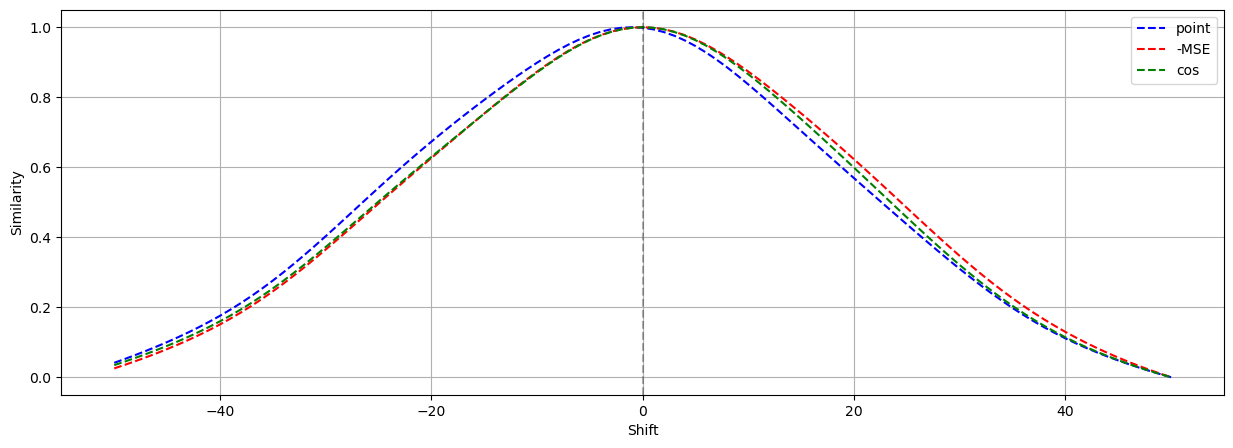

In [7]:
idx =2
# 获取原始信号
signal = data['ppg'][idx]   # 移除batch维度

len = 768
max_shift= 50

point_sims ,mses,cosine_sims =[],[],[]
for shift in range(-max_shift,max_shift+1): 
    # 获取对应的shifts

    start =100
    (start_B, end_B) = start+shift,start+len+shift
    (start_A, end_A) = start+0,start+0+len
    # print(start_A, end_A,start_B, end_B)

    point_sim ,mse,cosine_sim  = compute_similarity(signal[start_A:end_A], signal[start_B:end_B])
    point_sims.append(point_sim)
    mses.append(mse)
    cosine_sims.append(cosine_sim)

point_sims ,mses,cosine_sims = np.array(point_sims),np.array(mses),np.array(cosine_sims)

# 创建x轴范围
x = np.arange(-max_shift, max_shift+1)

plt.figure(figsize=(15, 5))

point_sims_norm = (point_sims - point_sims.min()) / (point_sims.max() - point_sims.min())
mses_norm = (mses - mses.min()) / (mses.max() - mses.min())
cosine_sims_norm = (cosine_sims - cosine_sims.min()) / (cosine_sims.max() - cosine_sims.min())

# 绘制三条曲线
plt.plot(x, point_sims_norm, 'b--', label='point')
plt.plot(x, 1-mses_norm, 'r--', label='-MSE')  # 使用负MSE便于观察最大值
plt.plot(x, cosine_sims_norm, 'g--', label='cos')
plt.xlabel('Shift')
plt.ylabel('Similarity')
plt.legend()
plt.grid(True)

# 添加竖直线标记零点
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)

plt.show()

    

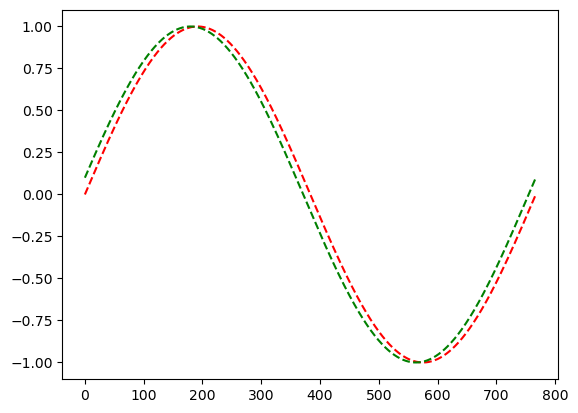

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the SeparateConvMetaNet
class SeparateConvMetaNet(nn.Module):
    def __init__(self, seq_length, feature_dim=64):
        super(SeparateConvMetaNet, self).__init__()
        self.feature_extractor_out = nn.Sequential(
            nn.Conv1d(1, feature_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(feature_dim, feature_dim, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.feature_extractor_label = nn.Sequential(
            nn.Conv1d(1, feature_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(feature_dim, feature_dim, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.regressor = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Output shift t
        )

    def compute_cosine_similarity(self, h_out, h_label):
        h_out_norm = F.normalize(h_out, p=2, dim=1)
        h_label_norm = F.normalize(h_label, p=2, dim=1)
        cosine_similarity = (h_out_norm * h_label_norm).sum(dim=1).mean(dim=1, keepdim=True)
        return cosine_similarity

    def forward(self, y_out, y_label):
        y_out = y_out.unsqueeze(1)  # Add channel dimension
        y_label = y_label.unsqueeze(1)
        h_out = self.feature_extractor_out(y_out)
        h_label = self.feature_extractor_label(y_label)
        cosine_similarity = self.compute_cosine_similarity(h_out, h_label)
        t = self.regressor(cosine_similarity)
        return t




In [34]:
def plotsig(signal1,signal2):
    plt.figure(figsize=(10,3))
    # signal1,signal2 =signal[start_A:end_A], signal[start_B:end_B]
    plt.plot(signal1)
    plt.plot(signal2)
    plt.show()

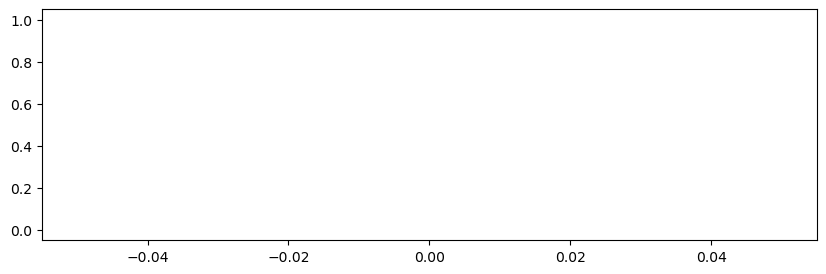

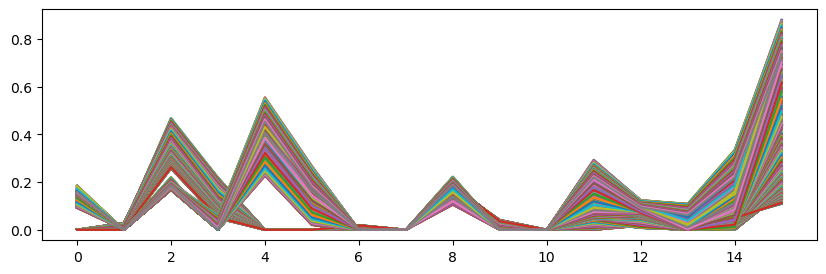

In [52]:
feature_dim = 16
feature_extractor_out = nn.Sequential(
            nn.Conv1d(1, feature_dim, kernel_size=3, ),
            nn.ReLU(),
            nn.Conv1d(feature_dim, feature_dim, kernel_size=3,  ),
            nn.ReLU()
        ) 
feature_extractor_label = nn.Sequential(
            nn.Conv1d(1, feature_dim, kernel_size=3,  ),
            nn.ReLU(),
            nn.Conv1d(feature_dim, feature_dim, kernel_size=3, ),
            nn.ReLU()
        ) 
signal1,signal2 =torch.from_numpy(signal[start_A:end_A]).unsqueeze(0).unsqueeze(1).float(),torch.from_numpy( signal[start_B:end_B]).unsqueeze(0).unsqueeze(1).float()
signal1.shape
plotsig(signal1[0],signal2[0])
signal1,signal2  = feature_extractor_out(signal1),feature_extractor_label(signal2)
plotsig(signal1[0].detach().numpy(),signal2[0].detach().numpy())

In [56]:
signal1.shape,signal2.shape

(torch.Size([1, 16, 764]), torch.Size([1, 16, 764]))

In [58]:
def compute_cosine_similarity( h_out, h_label):
        h_out_norm = F.normalize(h_out, p=2, dim=1)
        h_label_norm = F.normalize(h_label, p=2, dim=1)
        cosine_similarity = (h_out_norm * h_label_norm)
        print(cosine_similarity.shape)
        cosine_similarity=cosine_similarity.sum(dim=1)
        print(cosine_similarity.shape)
        cosine_similarity=cosine_similarity.mean(dim=1, keepdim=True)
        print(cosine_similarity.shape)
        return cosine_similarity

In [59]:
compute_cosine_similarity(signal1,signal2)

torch.Size([1, 16, 764])
torch.Size([1, 764])
torch.Size([1, 1])


tensor([[0.6441]], grad_fn=<MeanBackward1>)

In [53]:
signal1.shape

torch.Size([1, 16, 764])

In [ ]:
signal1.shape

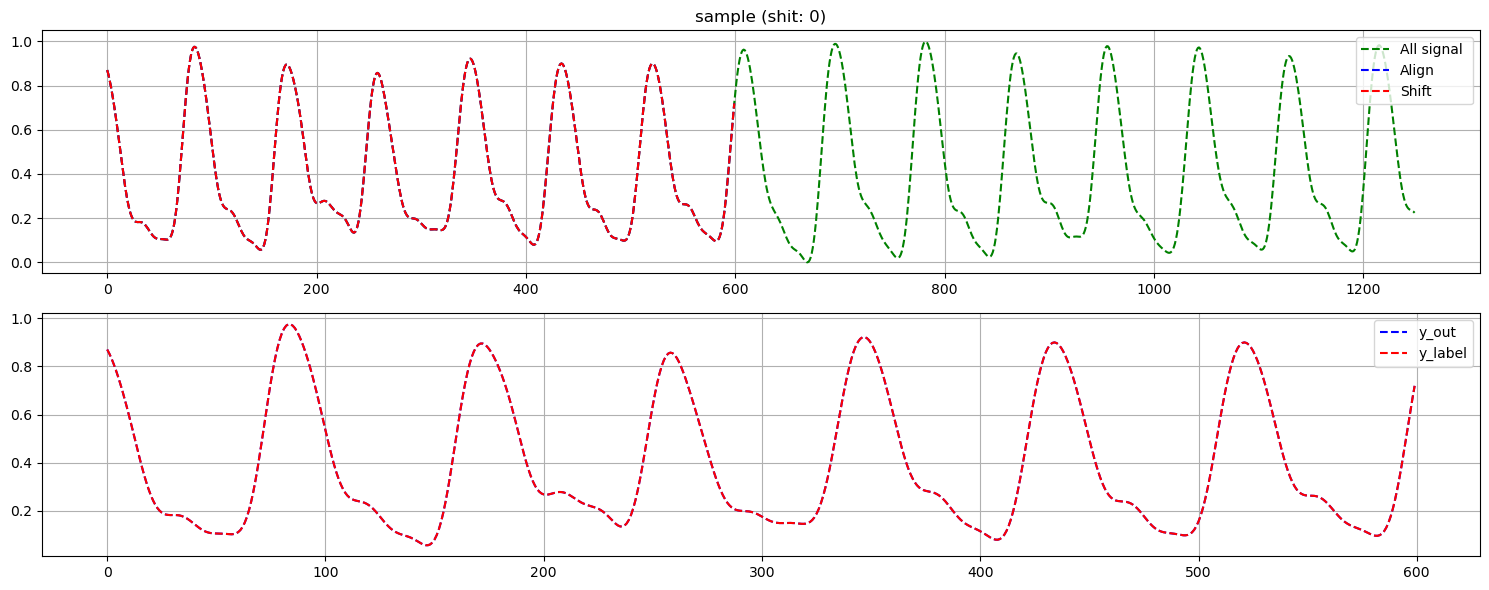

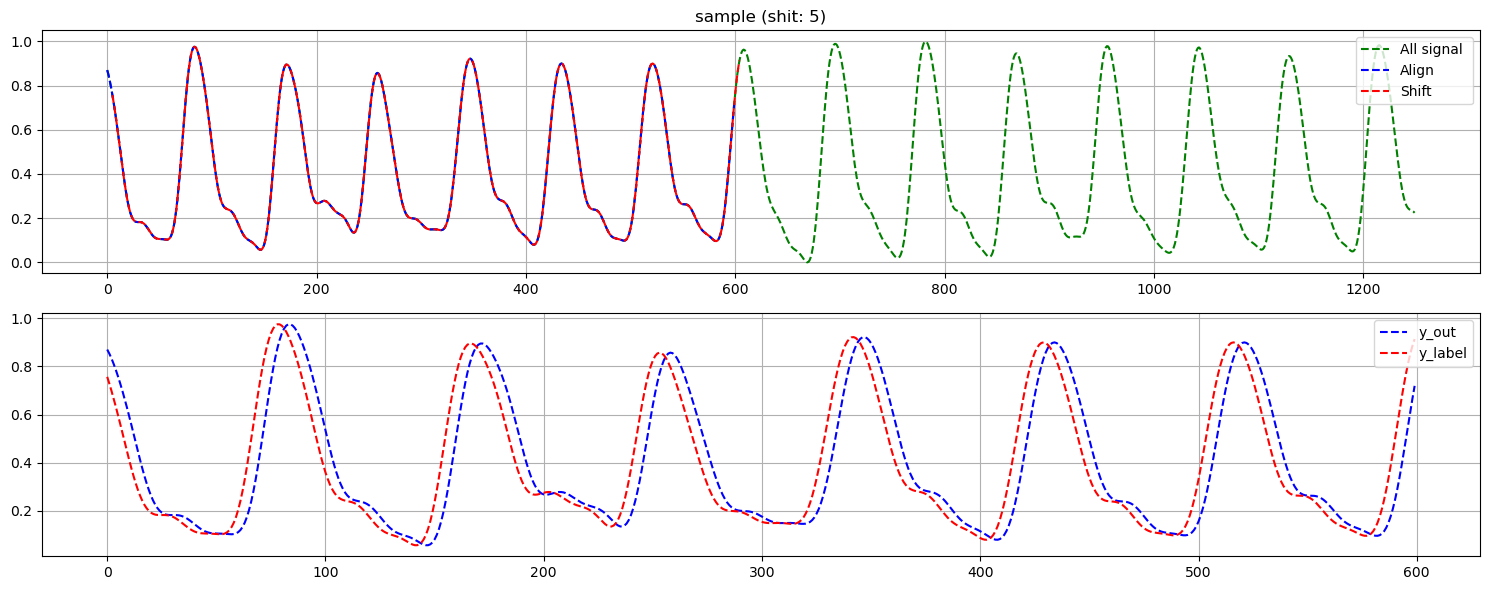

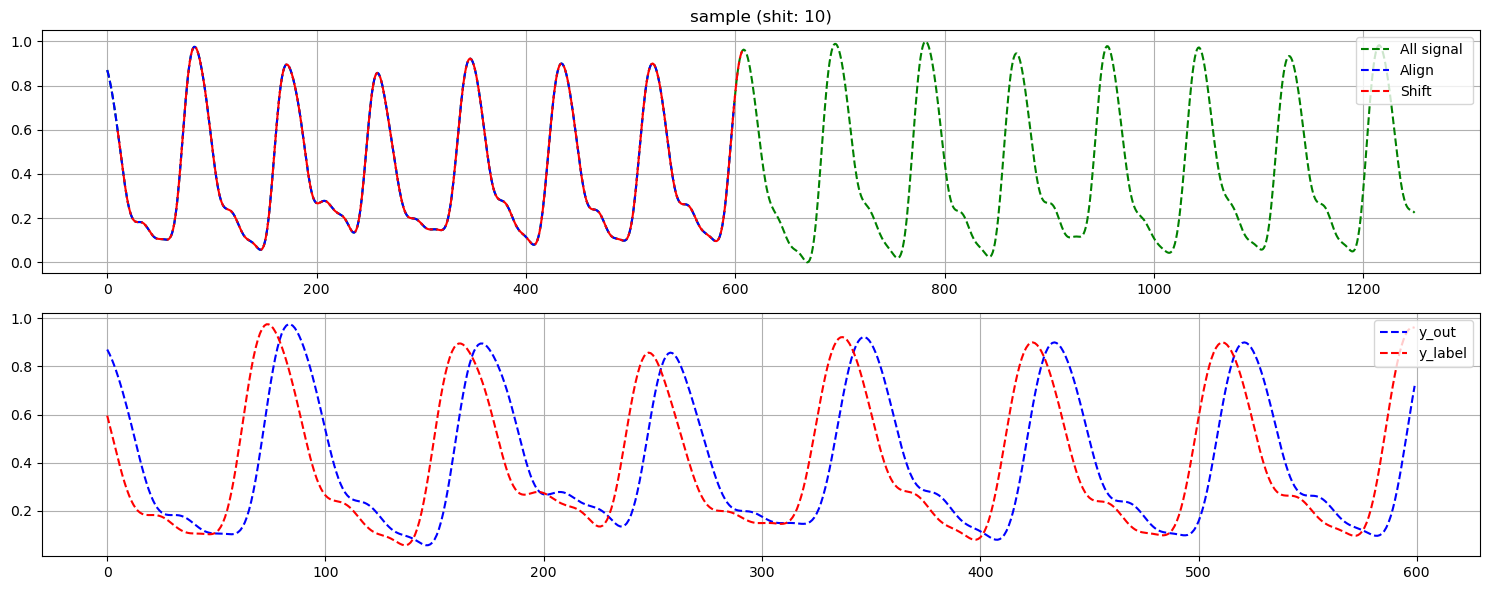

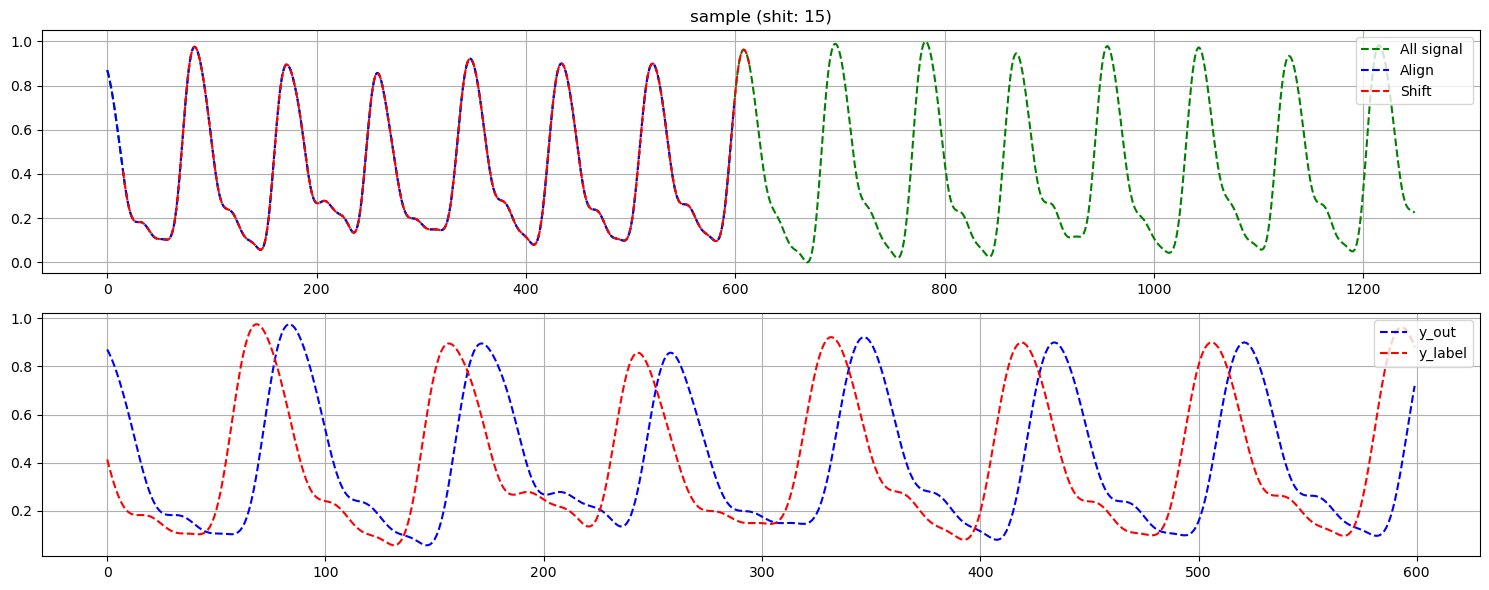

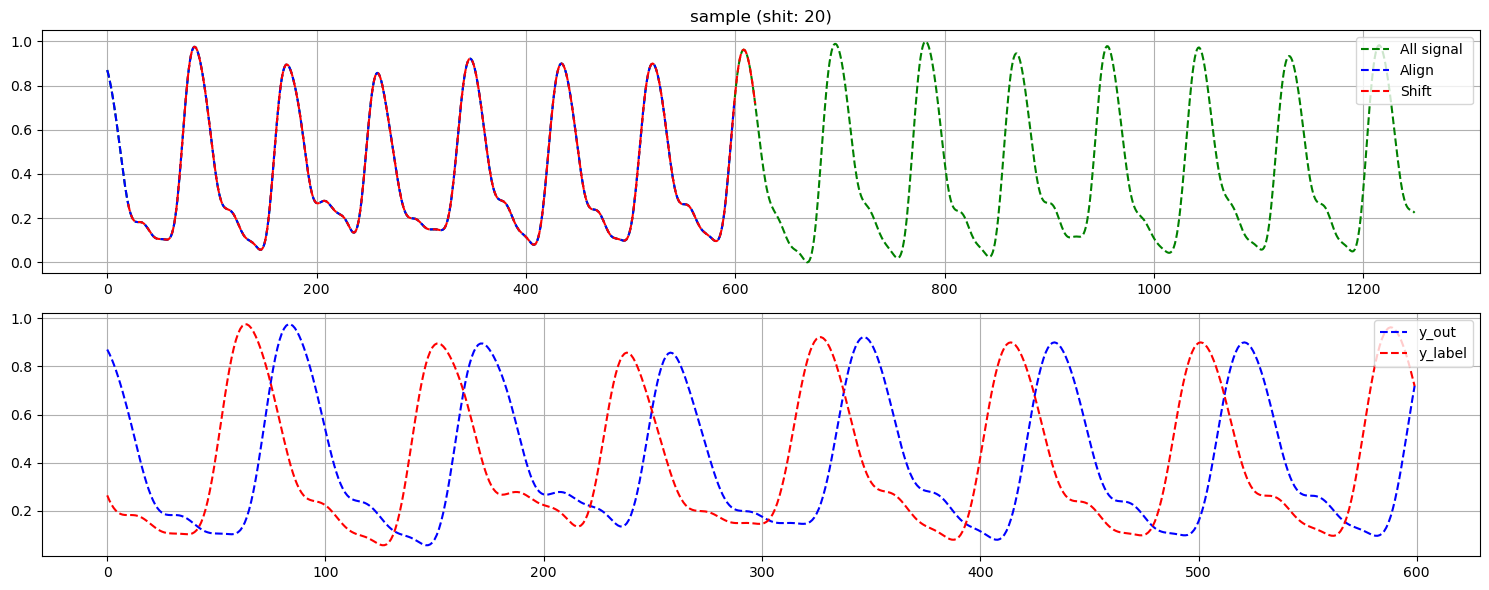

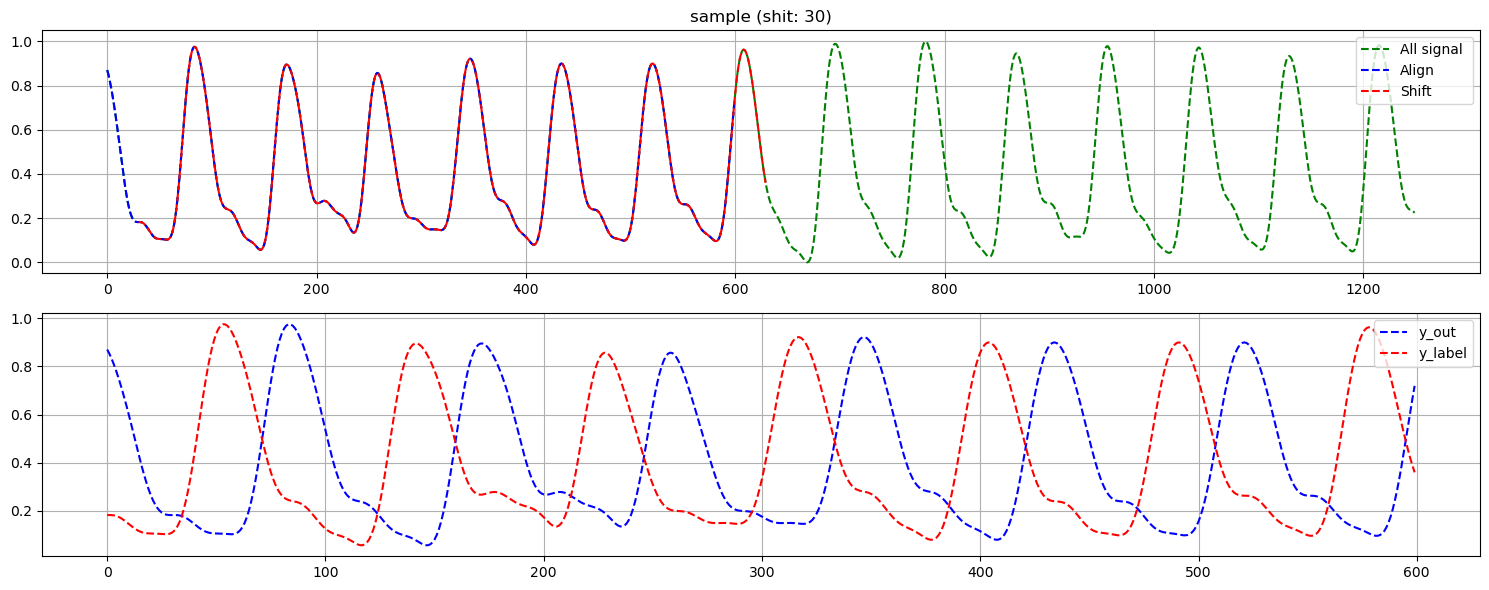

In [15]:


idx =0
# 获取原始信号
signal = data['ppg'][idx]   # 移除batch维度

len = 600
shifts = [0,5,10,15,20,30]

for shift in shifts:
    plt.figure(figsize=(15, 3*2))
    # 获取对应的shifts
    (start_B, end_B) = shift,len+shift
    (start_A, end_A) = 0,0+len

    # 绘制原始信号和偏移信号
    plt.subplot(2, 1, 1)
    plt.plot(range(0, 1250), signal , 'g--', label='All signal ')
    plt.plot(range(start_A, end_A), signal[start_A:end_A], 'b--', label='Align')
    plt.plot(range(start_B, end_B), signal[start_B:end_B], 'r--', label='Shift')
    plt.title(f'sample (shit: {start_B-start_A})')
    plt.legend(loc='upper right')
    plt.grid(True)

    # 绘制原始信号和偏移信号
    plt.subplot(2, 1, 2) 
    plt.plot(  signal[start_A:end_A], 'b--', label='y_out')
    plt.plot( signal[start_B:end_B], 'r--', label='y_label')
    
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [5]:


import numpy as np

def generate_shift_idx(signal, full_length=1250, segment_length=768, max_shift=125):
    """
    从一个完整信号生成一个固定的中心信号片段 A 和随机偏移的信号片段 B。

    Parameters:
    - signal: np.ndarray, 输入信号，长度为 full_length。
    - full_length: int, 完整信号的长度（默认为1250）。
    - segment_length: int, 片段信号的长度（默认为768）。 

    Returns:
    - signal_A: np.ndarray, 最中央的信号片段 A。
    - signal_B: np.ndarray, 随机偏移的信号片段 B。
    """
    if len(signal) != full_length:
        raise ValueError(f"Input signal must have length {full_length}.")
    
    if max_shift > segment_length:
        raise ValueError("segment_length must be smaller than segment_length.")
    
    # 确定信号 A 的起始点（最中央部分）
    start_A = (full_length - segment_length) // 2
    end_A = start_A + segment_length 
    

    # 随机生成偏移值（正向或负向）
    shift = np.random.randint(-max_shift, max_shift + 1)
    start_B = start_A + shift
  
    # 确保 B 不超出信号范围
    start_B = max(0, min(full_length - segment_length, start_B))
    end_B = start_B + segment_length
    
    return (start_A,end_A),(start_B,end_B),shift




In [6]:
def generate_and_save_shifts_p(data_type, length, prob=0.6,full_length=1250, segment_length=768, max_shift=25,seed = 42):
    """
    为指定数据集生成时间偏移并保存
    
    参数:
    - data_type: str, 'train'/'val'/'test' 之一
    - length: int, 数据集长度
    - full_length: int, 完整信号长度
    - segment_length: int, 片段长度
    - max_shift: int, 最大偏移量
    """
    np.random.seed(42)  # 设置固定的随机种子
    random.seed(42)     # 同时设置Python的random种子
    
    shifts = []
    center = []
    ss = []
    for _ in range(length):
      
        idx_center, idx_shift,s = generate_shift_idx(
            np.zeros(full_length),
            full_length=full_length,
            segment_length=segment_length,
            max_shift=max_shift
        )
     
        if np.random.rand() <= prob:# 以prob=0.6的概率生成偏移
            shifts.append(idx_shift)
        else:
            shifts.append(idx_center)
        center.append( idx_center  )
        ss.append(s)
    
    shifts = np.array(shifts)
    center = np.array(center)
    ss = np.array(ss)
    
    # 构建保存路径
    save_path = f'/data/home/qian_hong/signal/vitaldb/0/shift_id/{data_type}_{max_shift}_{prob}.npz'
    
    # 保存数据
    np.savez(save_path,
             shifts=shifts,
             center=center,
             s = ss,
             full_length=full_length,
             segment_length=segment_length,
             max_shift=max_shift)
    
    print(f'{data_type} 集时间偏移已保存至: {save_path}')



In [7]:
# 为三个数据集分别生成并保存
max_shift = 50
for prob in [0.3,0.4,0.7,1.0]:

    generate_and_save_shifts_p('train', len_train,prob=prob,max_shift=max_shift)
    generate_and_save_shifts_p('val', len_val,prob=prob,max_shift=max_shift)
    generate_and_save_shifts_p('test', len_test,prob=prob,max_shift=max_shift)

train 集时间偏移已保存至: /data/home/qian_hong/signal/vitaldb/0/shift_id/train_50_0.4.npz
val 集时间偏移已保存至: /data/home/qian_hong/signal/vitaldb/0/shift_id/val_50_0.4.npz
test 集时间偏移已保存至: /data/home/qian_hong/signal/vitaldb/0/shift_id/test_50_0.4.npz


In [7]:
shifts_train = np.load('/data/home/qian_hong/signal/vitaldb/0/shift_id/test_50_1.0.npz')

In [ ]:
shifts_train

In [14]:
shifts_train['s'].shape,np.array([0]*10).shape

((5760,), (10,))

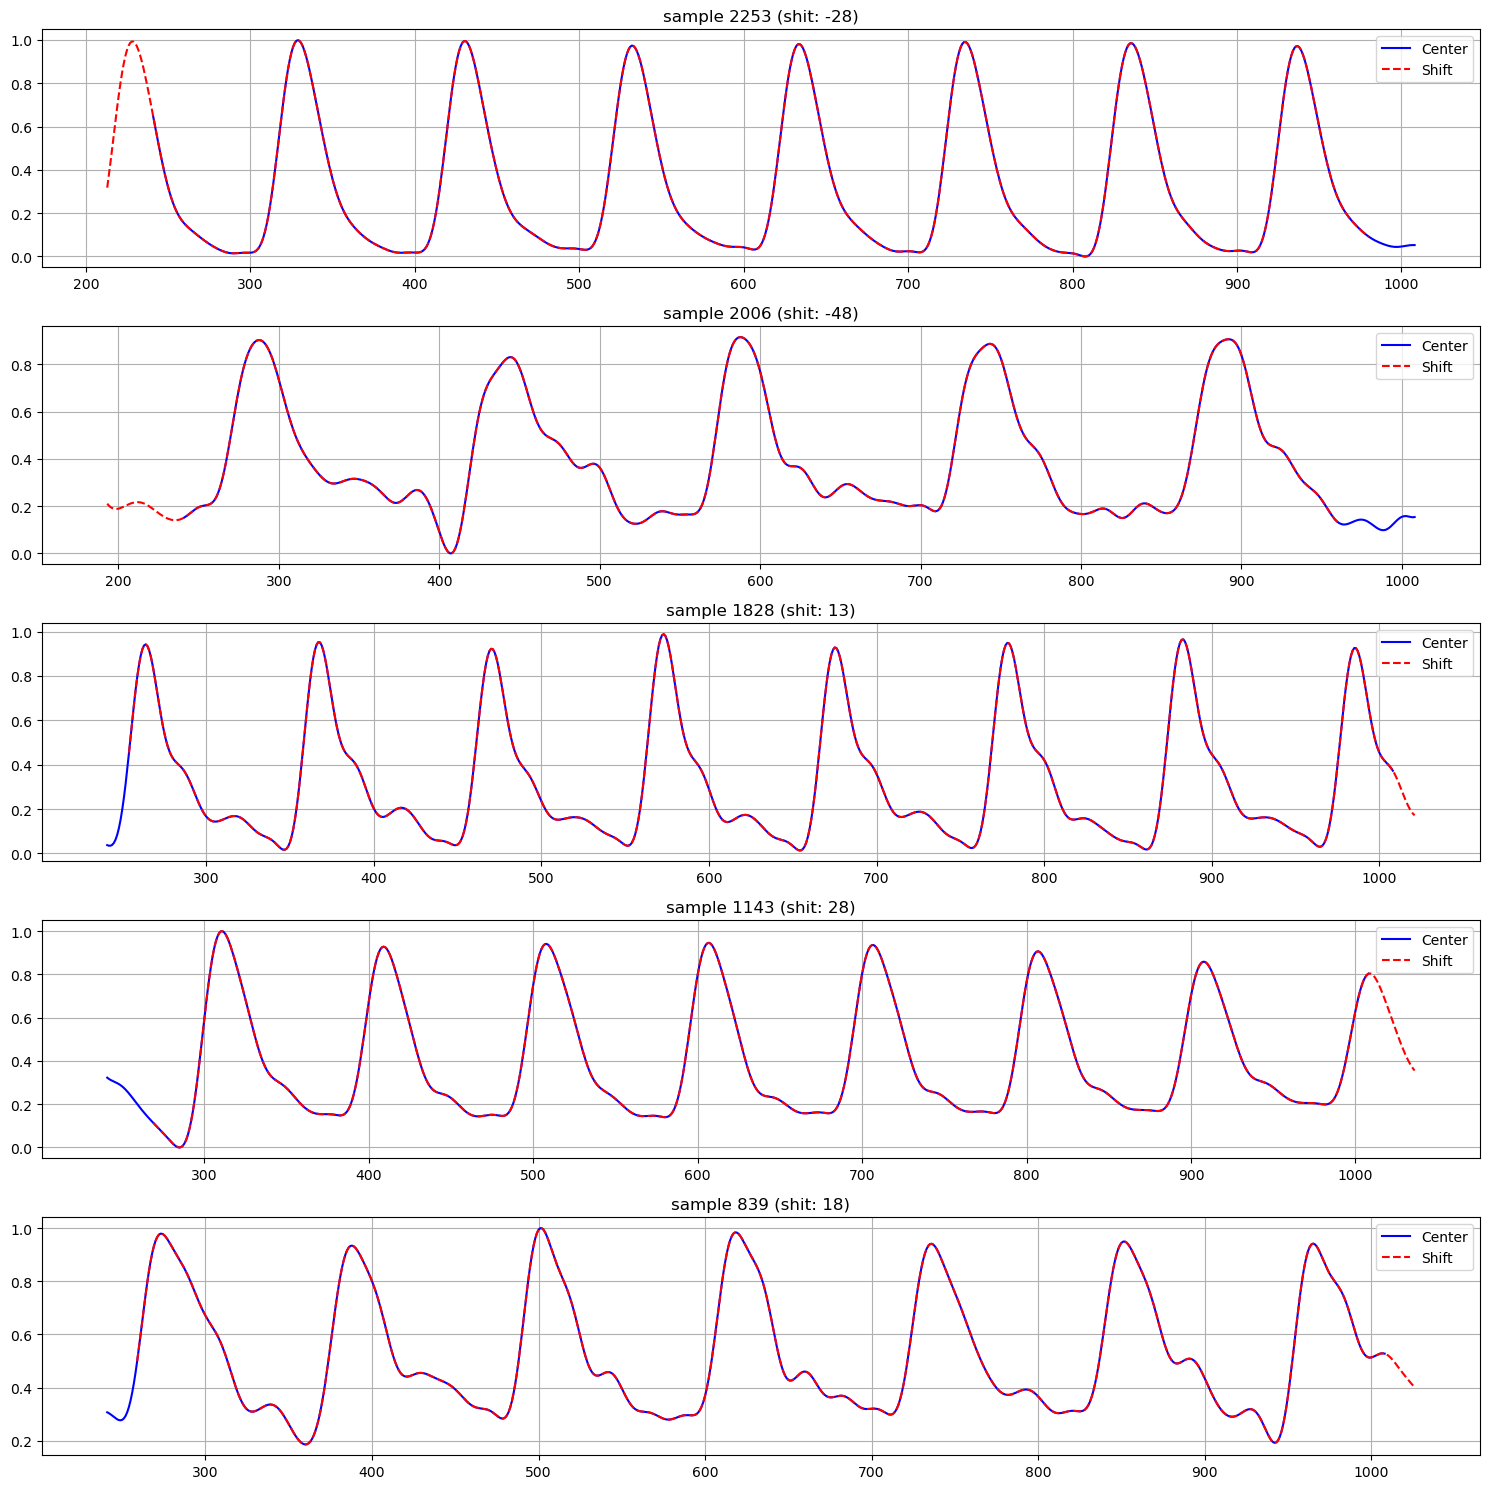

In [9]:
# 随机选择几个样本进行可视化
n_samples = 5  # 展示3个样本
random_indices = random.sample(range(len(data['ppg'])), n_samples) 
plt.figure(figsize=(15, 3*n_samples))

for i, idx in enumerate(random_indices):
    # 获取原始信号
    signal = data['ppg'][idx]   # 移除batch维度
    
    # 获取对应的shifts
    (start_B, end_B) = shifts_train['shifts'][idx]
    (start_A, end_A) = shifts_train['center'][idx]
    
    # 绘制原始信号和偏移信号
    plt.subplot(n_samples, 1, i+1)
    plt.plot(range(start_A, end_A), signal[start_A:end_A], 'b-', label='Center')
    plt.plot(range(start_B, end_B), signal[start_B:end_B], 'r--', label='Shift')
    plt.title(f'sample {idx} (shit: {start_B-start_A})')
    plt.legend(loc='upper right')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [16]:

def gen_shift_idx(num_samples=1250, overlap=0.9):
    start_idx = np.random.randint(0, num_samples - int(overlap * num_samples))  # 随机起始索引
    end_idx = start_idx + int(overlap * num_samples)   # 计算连续区间的结束索引
    return start_idx, end_idx


In [3]:
ppg,bp,ecg = [
               torch.from_numpy( (data[f'{sig}'] )).to(torch.float32).unsqueeze(1) 
               for sig in ['ppg','bp','ecg' ]
            ]
        
sbp,dbp = [
        torch.from_numpy( (data[f'{sig}'] )).to(torch.float32).unsqueeze(1) 
        for sig in ['sbp','dbp' ]
    ]
ppg.shape


torch.Size([21886, 1, 1024])